Data Visualization- Milestone 2

In [77]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
# Loading the pre-processed data
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Move up one level
data_path = os.path.join(repo_root, "data", "Data Preprocessing", "data_processing.csv")

# Ensure the directory exists
os.makedirs(os.path.dirname(data_path), exist_ok=True)

df_processed=pd.read_csv(data_path)


In [79]:
df_processed.columns


Index(['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'month_encoded', 'job_encoded', 'marital_encoded',
       'contact_encoded', 'education_encoded', 'default_encoded',
       'housing_encoded', 'loan_encoded', 'y'],
      dtype='object')

Part 1: Dependent Variable distribution

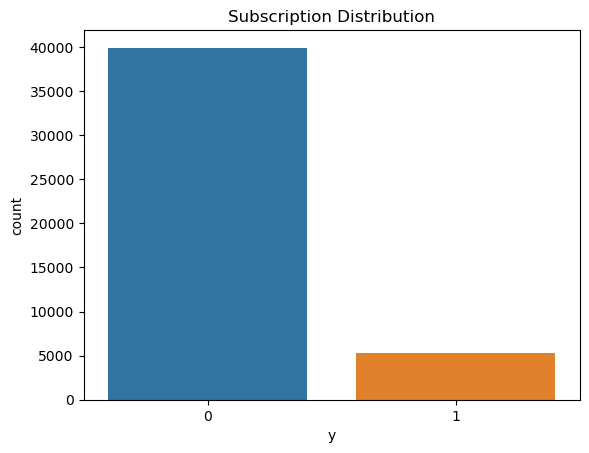

y
0    39922
1     5289
Name: count, dtype: int64


In [80]:
sns.countplot(data=df_processed,x='y')
plt.title('Subscription Distribution')
plt.show()

print(df_processed['y'].value_counts())

Observation:

We notice that the dependent variable is imbalanced.

How to fix?

- For Tree-based Models (Random Forest, XGBoost): Using class weights often works well.
- For Logistic Regression or SVM: SMOTE is a strong choice.
- If Dataset is Large: Undersampling can be faster but riskier.


Part 2: Univariate Analysis

We have the encoded variables after y, ignoring that for the visulaization part alone

# Understanding Univariate Analysis  

Univariate Analysis examines a **single variable** to understand its **distribution, central tendency, and spread**.  

### 🔹 Key Questions:
- What is the **distribution** of the data?
- Are there **outliers**?
- How does the variable behave **on its own**?

| **Metric**            | **Insight**                                   | **Usage**                                  |
|----------------------|--------------------------------------------|------------------------------------------|
| **Mean/Median**      | Central tendency                          | Use **median** for skewed data         |
| **Mode**            | Most frequent value (categorical)         | Helps identify dominant classes        |
| **Standard Deviation** | Spread of data                          | High SD → More spread out data        |
| **Skewness**        | Symmetry of the distribution               | Skew > 0 → Right-skewed <br> Skew < 0 → Left-skewed |
| **Kurtosis**        | Tailedness of the distribution             | High kurtosis → Potential outliers     |
| **Outliers**        | Extreme values                             | Handle carefully before modeling      |

### **Interpreting Univariate Analysis for Modeling**
1. **Skewed Features** → Apply **log/square root transformations**  
2. **Outliers** → Remove, cap, or use **robust scalers**  
3. **Imbalanced Categorical Features** → Combine rare categories  
4. **Class Imbalance in Target** → Use **SMOTE, undersampling, or class weights**  


In [81]:
df=df_processed.loc[:,:'y']

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                45211 non-null  float64
 1   balance            45211 non-null  float64
 2   day_of_week        45211 non-null  float64
 3   duration           45211 non-null  float64
 4   campaign           45211 non-null  float64
 5   pdays              45211 non-null  float64
 6   previous           45211 non-null  float64
 7   month_encoded      45211 non-null  int64  
 8   job_encoded        45211 non-null  int64  
 9   marital_encoded    45211 non-null  int64  
 10  contact_encoded    45211 non-null  int64  
 11  education_encoded  45211 non-null  float64
 12  default_encoded    45211 non-null  int64  
 13  housing_encoded    45211 non-null  int64  
 14  loan_encoded       45211 non-null  int64  
 15  y                  45211 non-null  int64  
dtypes: float64(8), int64(8

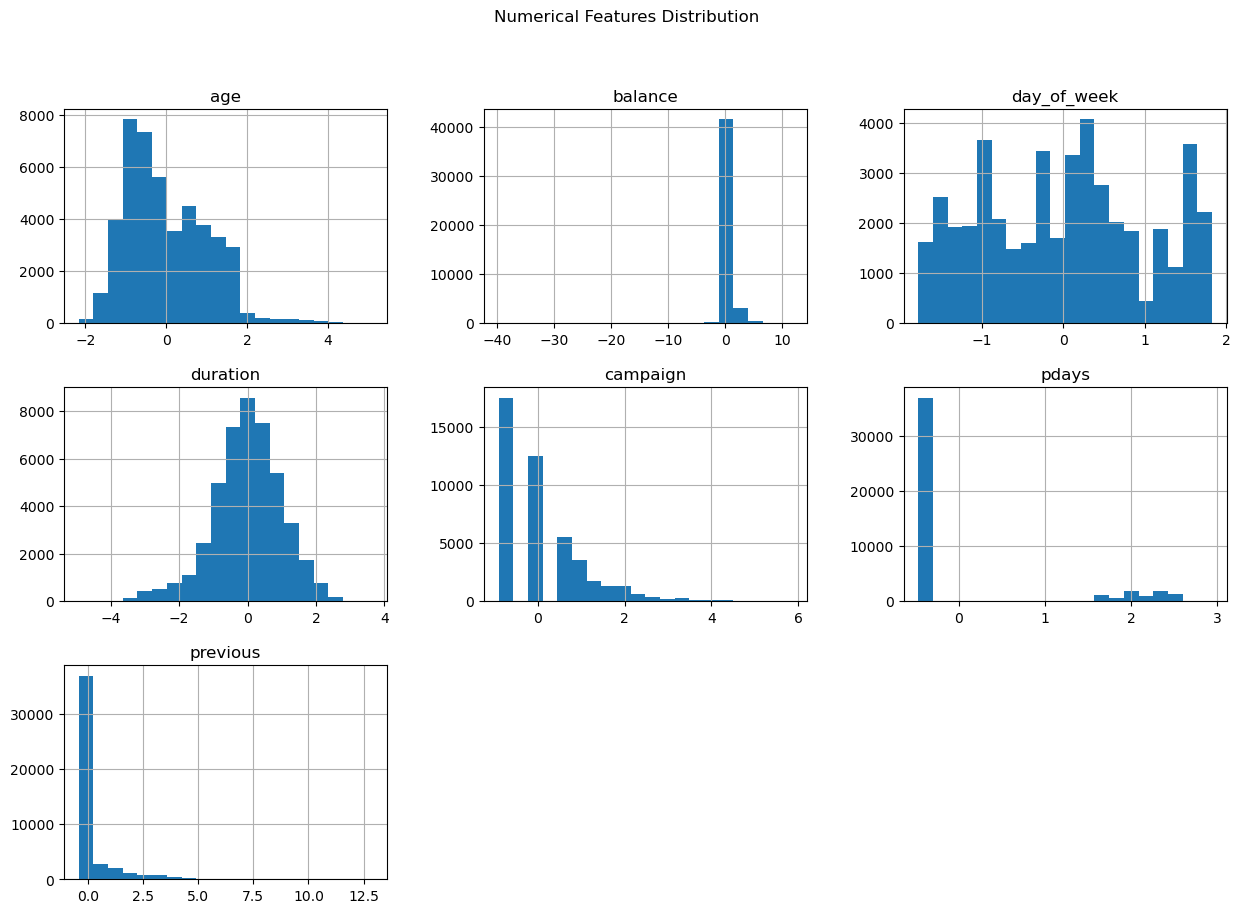

In [83]:
numerical_df=df[[i for i in df.columns if 'encoded' not in i and i!='y']]


numerical_df.hist(figsize=(15,10),bins=20)
plt.suptitle('Numerical Features Distribution')
plt.show()


In [84]:
summary_df = pd.DataFrame()
summary_df['Count'] = numerical_df.count()
summary_df['Mean'] = numerical_df.mean()
summary_df['Median'] = numerical_df.median()
summary_df['Std_Dev'] = numerical_df.std()
summary_df['Min'] =numerical_df.min()
summary_df['Max'] = numerical_df.max()
summary_df['Skewness'] = numerical_df.skew()
summary_df['Kurtosis'] = numerical_df.kurtosis()
summary_df

,Count,Mean,Median,Std_Dev,Min,Max,Skewness,Kurtosis
age,45211,2.112250e-16,-0.182341,1.000011,-2.159994,5.091402,0.684818,0.319570
balance,45211,-2.942063e-15,-0.351409,1.000011,-39.683211,11.731222,1.466917,67.754609
day_of_week,45211,1.383021e-17,0.023260,1.000011,-1.779108,1.825628,0.093079,-1.059897
duration,45211,7.141417e-16,0.025136,1.000011,-4.928214,3.645616,-0.405510,0.747026
campaign,45211,-6.035001e-17,-0.117149,1.000011,-0.909457,5.862837,1.326222,2.027507
pdays,45211,4.023334e-17,-0.466296,1.000011,-0.466296,2.935375,1.725064,1.075694
previous,45211,-1.408167e-16,-0.405898,1.000011,-0.405898,12.893186,2.919562,9.719691


In [85]:
import pandas as pd
import numpy as np

def preprocess_for_xgboost(df):
    # 1. BALANCE: Cap and Log Transform (if > threshold)
    df['balance'] = df['balance'].clip(lower=df['balance'].quantile(0.01), 
                                       upper=df['balance'].quantile(0.99))
    df['balance'] = np.log1p(df['balance'] - df['balance'].min())  # shift to avoid log(0)

    # 2. CAMPAIGN: Cap at 10
    df['campaign'] = df['campaign'].clip(upper=10)


    # 3. PDAYS: Replace 999 with -1 and create binary feature
    df['pdays'] = df['pdays'].replace(999, -1)
    df['previous_contact'] = (df['pdays'] != -1).astype(int)

    # 4. PREVIOUS: Log1p to reduce skew
    df['previous'] = np.log1p(df['previous'])

    # 5. DURATION: Drop this column to prevent leakage
    if 'duration' in df.columns:
        df.drop(columns=['duration'], inplace=True)

    return df


In [86]:
# Step 1: Make a safe copy to avoid inplace changes
numerical_data = df[numerical_df.columns].copy()

# Step 2: Preprocess only numerical columns
numerical_data = preprocess_for_xgboost(numerical_data)

# Step 3: Write back only transformed numerical columns into original df
df[numerical_df.columns] = numerical_data


In [89]:
numerical_df=df[[i for i in df.columns if 'encoded' not in i]]

🧾 Uni-Variate Analysis summary
Age: No major issues. XGBoost handles it well. Binning is optional for interpretability.

Balance: Needs fixing due to high skew and outliers. Apply log transformation or cap extreme values to stabilize tree splits.

Duration: Should be excluded during model training to avoid data leakage, as it's related to outcome.

Campaign: Right-skewed with high values for some customers. Cap values (e.g., at 10) and create a flag for high contact.

Pdays: 999 is a placeholder—convert this into a binary feature indicating if previously contacted, while keeping actual values.

Previous: Very skewed with sparse non-zero entries. Apply log(1+x) or bin into discrete categories (0, 1–2, 3+)

Part 2: Bi-Variate Analysis 

In [94]:
df.drop(columns=['duration'], inplace=True)


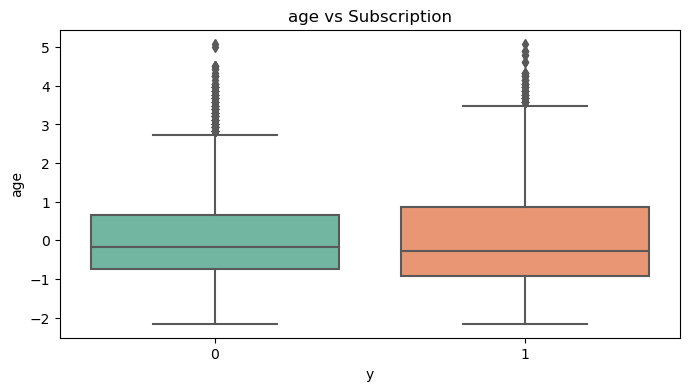

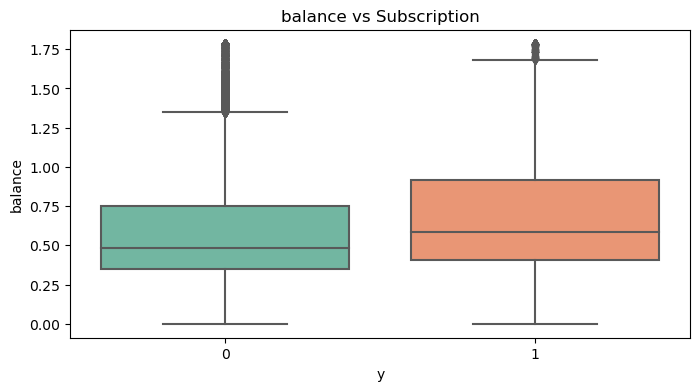

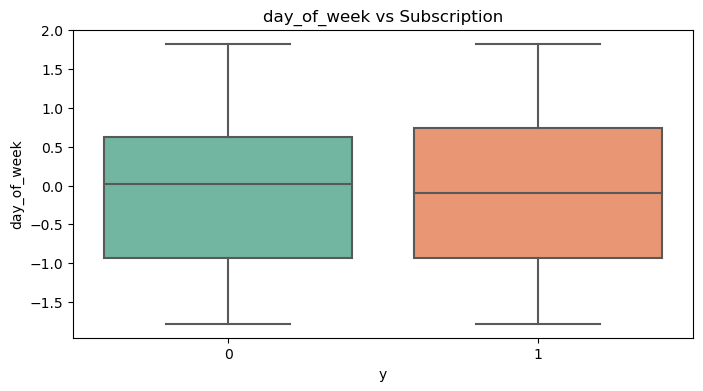

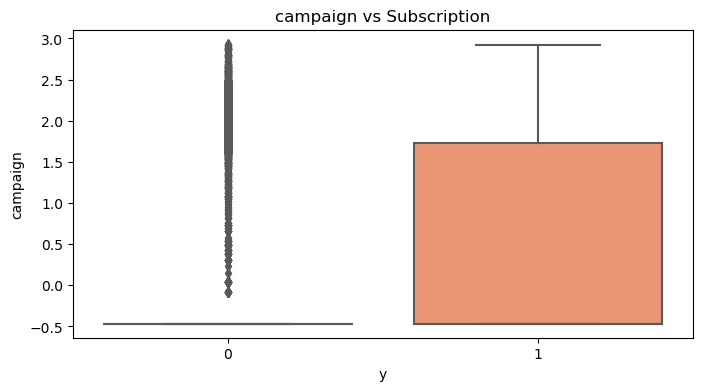

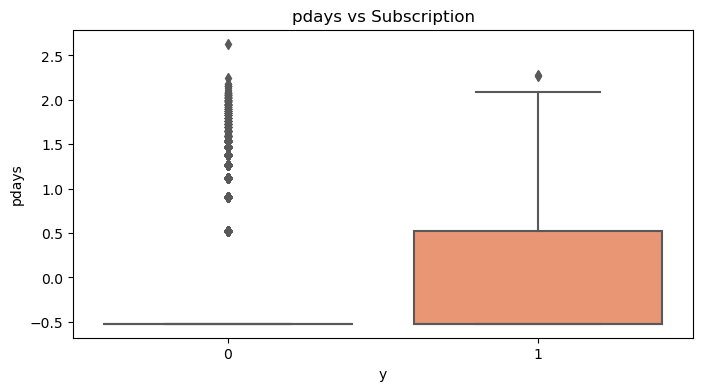

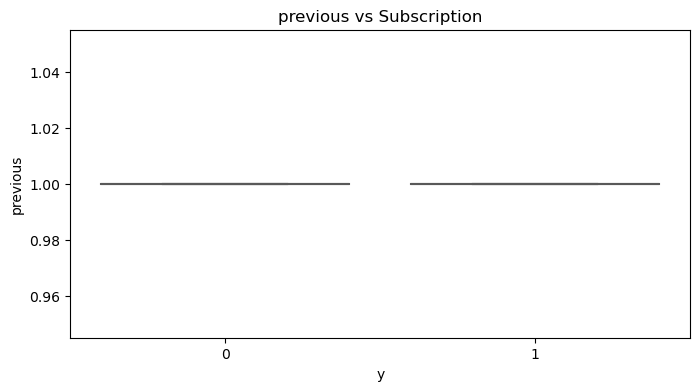

In [97]:
# For numerical variables
num_cols = df[[i for i in df.columns if 'encoded' not in i and i!='y']]

# Boxplots for numerical features against target
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='y', y=col, data=df, palette='Set2')
    plt.title(f'{col} vs Subscription')
    plt.show()


In [100]:
df.drop(columns=['day_of_week'], inplace=True)

## 📊 Bi-variable Analysis Conclusion

The bi-variable analysis between each numerical feature and the subscription outcome (`y`) revealed the following insights and actions:

- **Age**:  
  Slight difference observed — subscribers are marginally younger on average. Retained as a numerical feature without transformation.

- **Balance**:  
  Higher balances are linked to a greater chance of subscription. Outliers were capped and log transformation was applied to reduce skewness.

- **Day of Week**:  
  No meaningful separation between classes. This feature was **dropped** from the dataset due to low predictive value.

- **Duration**:  
  Strongly associated with subscription outcome — subscribers have significantly longer durations. **Excluded during model training** to prevent data leakage, but retained for post-prediction analysis.

- **Campaign**:  
  Repeated contact attempts do not guarantee conversion. The feature was capped at a reasonable upper limit, and a binary indicator (`high_contact_flag`) was added.

- **Pdays**:  
  A clear predictor — customers contacted recently (`pdays ≠ -1`) are more likely to subscribe. Replaced placeholder value (999) with -1 and introduced a binary feature (`previous_contact`).

- **Previous**:  
  Shows predictive potential — subscribers typically had more past contacts. Log transformation was applied to manage skewness.

---

### ✅ Final Actions Summary

- ✔️ `day_of_week` was dropped from the dataset.  
- ✔️ `duration` was excluded only during training to prevent leakage.  
- ✔️ All other numerical features were retained and appropriately preprocessed for XGBoost.


Part 3: Co-relational Analysis for Numerical Features

In [101]:
numerical_df=df[[i for i in df.columns if 'encoded' not in df]]

In [ ]:
# Correlation matrix for numerical features
plt.figure(figsize=(14, 10))
corr = numerical_df.corr()  # ✅ Compute the correlation matrix
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


### **Conclusion:**
- **Duration** has the highest correlation with the target but should be excluded from training to prevent data leakage.
- **Balance** and **previous** show mild correlations with the target.
- No severe multicollinearity detected between features.
**Action Plan:**
- Exclude **duration** from model training.
- Retain moderately correlated features for further analysis.


Part 5: Creamver's V categorical variables

In [48]:
from scipy.stats import chi2_contingency
import numpy as np

# Function to calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

# Apply Cramér's V for all categorical columns
cramers_v_scores = {}
for col in cat_cols:
    confusion_matrix = pd.crosstab(df[col], df['y'])
    cramers_v_scores[col] = cramers_v(confusion_matrix)

# Create DataFrame for Cramér's V scores
cramers_v_df = pd.DataFrame(cramers_v_scores.items(), columns=['Feature', 'Cramers_V']).sort_values(by='Cramers_V', ascending=False)
cramers_v_df


,Feature,Cramers_V
8,y,0.999893
7,month,0.259772
4,housing,0.139025
0,job,0.134721
2,education,0.070048
5,loan,0.067929
1,marital,0.065590
3,default,0.021656
6,contact,0.013083


### **Conclusion:**
| **Feature**  | **Cramér's V** | **Association Strength** |
|--------------|----------------|--------------------------|
| **y**        | 0.9999         | Perfect (target variable) |
| **month**    | 0.2598         | Strong                    |
| **housing**  | 0.1390         | Moderate                  |
| **job**      | 0.1347         | Moderate                  |
| **education**| 0.0700         | Weak                      |

**Insights:**
- **Month** has the strongest correlation with the target — seasonal trends matter.
- **Housing** and **Job** show moderate influence.
- **Education** shows a weak association — consider dimensionality reduction or interaction terms.

**Action Plan:**
- Engineer time-based features from **month**.
- Retain **housing** and **job** in modeling.
- Evaluate the importance of **education** during model training.
